## Capstone Three: Pre-processing, Training Data Development, and Modeling for Chest X-Ray Images

### I. Project Setup and Library Imports

The first step is to ensure all necessary libraries are installed and imported. These libraries provide the tools for data handling, image processing, model building, and evaluation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3 

### II. Data Loading and Initial Preparation

The dataset is assumed to follow a standard directory structure: main_dir/train/{NORMAL, PNEUMONIA}, main_dir/val/{NORMAL, PNEUMONIA}, and main_dir/test/{NORMAL, PNEUMONIA}. The initial preparation involves defining these paths and understanding the dataset's organization for efficient loading.

In [2]:
base_dir = "/Users/ilkinguliyev/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

While ImageDataGenerator.flow_from_directory can directly handle the directory structure, creating dataframes can be useful for more granular control or additional EDA.

In [3]:
def load_image_paths_and_labels(directory, set_name):
    filepaths = []
    labels = []
    for label_name in os.listdir(directory):
        label_path = os.path.join(directory, label_name)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                filepaths.append(os.path.join(label_path, img_name))
                labels.append(label_name)
    return pd.DataFrame({'path': filepaths, 'label': labels, 'set': set_name})

train_df = load_image_paths_and_labels(train_dir, 'train')
val_df = load_image_paths_and_labels(val_dir, 'val')
test_df = load_image_paths_and_labels(test_dir, 'test')

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 5216
Validation samples: 16
Test samples: 624


### III. Pre-processing and Training Data Development

This critical phase prepares the image data for consumption by the deep learning model. It involves resizing, normalization, and data augmentation to enhance model generalization and prevent overfitting.

Define Image Dimensions and Batch Size:
Consistent image dimensions are essential for CNN input. Common sizes for pre-trained models are selected.

In [4]:
IMG_HEIGHT = 224 
IMG_WIDTH = 224
BATCH_SIZE = 32 
NUM_CLASSES = 2 # 'NORMAL', 'PNEUMONIA'

Data Augmentation Strategy:
Data augmentation artificially expands the training dataset by applying various transformations to the images. This helps the model learn more robust features and reduces overfitting.

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest' 
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Create Data Generators:
ImageDataGenerator.flow_from_directory is used to efficiently load images in batches directly from their respective directories, applying the defined pre-processing and augmentation steps.

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary', 
    shuffle=True 
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False 
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False 
)

print("Class indices:", train_generator.class_indices)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Class indices: {'NORMAL': 0, 'PNEUMONIA': 1}


Handle Class Imbalance:
If the dataset exhibits class imbalance (e.g., more NORMAL images than PNEUMONIA), weighting the classes during training can prevent the model from becoming biased towards the majority class.

In [7]:
# Get the counts of each class from the training generator
class_labels = train_generator.classes
total_samples = len(class_labels)
unique_classes, counts = np.unique(class_labels, return_counts=True)
class_weights = {}
for i, count in zip(unique_classes, counts):
    class_weights[i] = total_samples / (NUM_CLASSES * count)

print("Calculated class weights:", class_weights)

Calculated class weights: {np.int32(0): np.float64(1.9448173005219984), np.int32(1): np.float64(0.6730322580645162)}


### IV. Modeling

This section details the construction, compilation, and training of the deep learning model. Transfer learning with a pre-trained CNN is generally recommended for image classification tasks with limited datasets, as it leverages features learned from vast image collections.

Choose a Model Architecture:

Pre-trained models like ResNet50, VGG16, or InceptionV3 offer excellent starting points. We'll use ResNet50 as an example. The base model's layers are frozen, and a custom classification head is added.

In [8]:
def build_transfer_model(base_model_name='ResNet50', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES):
    if base_model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Unsupported base model name. Choose from 'VGG16', 'ResNet50', 'InceptionV3'.")

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x) 
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x) 
    predictions = Dense(1, activation='sigmoid')(x) # For binary classification (2 classes)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

model = build_transfer_model(base_model_name='ResNet50')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Compile the Model:

The model is compiled with an optimizer, a loss function, and metrics to monitor during training. For binary classification, binary_crossentropy is the appropriate loss.

In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = 'binary_crossentropy'
metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

Define Callbacks:

Callbacks are essential for controlling the training process, preventing overfitting, and saving the best performing model.

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_pneumonia_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stopping, reduce_lr, model_checkpoint]

Train the Model:

The model is trained using the prepared data generators, with the defined epochs and callbacks.

In [11]:
EPOCHS = 50 

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=val_generator.samples // BATCH_SIZE,
    class_weight=class_weights, 
    callbacks=callbacks
)



/Users/ilkinguliyev/opt/anaconda3/envs/chestxray/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - accuracy: 0.5271 - auc: 0.5507 - loss: 0.7416 - precision: 0.7785 - recall: 0.5147
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 920ms/step - accuracy: 0.5272 - auc: 0.5510 - loss: 0.7413 - precision: 0.7786 - recall: 0.5147 - val_accuracy: 0.5625 - val_auc: 0.8594 - val_loss: 0.6654 - val_precision: 0.5333 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.6676 - auc: 0.7003 - loss: 0.6395 - precision: 0.8423 - recall: 0.6830
Epoch 2: val_accuracy improved from 0.56250 to 0.62500, saving model to best_pneumonia_model.h5


163/163 ━━━━━━━━━━━━━━━━━━━━ 151s 923ms/step - accuracy: 0.6676 - auc: 0.7004 - loss: 0.6394 - precision: 0.8423 - recall: 0.6829 - val_accuracy: 0.6250 - val_auc: 0.8516 - val_loss: 0.6256 - val_precision: 0.5833 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 872ms/step - accuracy: 0.6688 - auc: 0.7360 - loss: 0.6110 - precision: 0.8547 - recall: 0.6690
Epoch 3: val_accuracy did not improve from 0.62500
163/163 ━━━━━━━━━━━━━━━━━━━━ 143s 876ms/step - accuracy: 0.6688 - auc: 0.7360 - loss: 0.6109 - precision: 0.8547 - recall: 0.6690 - val_accuracy: 0.6250 - val_auc: 0.8438 - val_loss: 0.6067 - val_precision: 0.5833 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.7085 - auc: 0.7705 - loss: 0.5930 - precision: 0.8671 - recall: 0.7098
Epoch 4: val_accuracy did not improve from 0.62500
163/163 ━━━━━━━━━━━━━━━━━━━━ 149s 913ms/step - accuracy: 0.7085 - auc: 0.7705 - loss: 0.5929 - precisi

163/163 ━━━━━━━━━━━━━━━━━━━━ 147s 899ms/step - accuracy: 0.7333 - auc: 0.7940 - loss: 0.5642 - precision: 0.8854 - recall: 0.7360 - val_accuracy: 0.6875 - val_auc: 0.8359 - val_loss: 0.5702 - val_precision: 0.6364 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 6/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7518 - auc: 0.7964 - loss: 0.5505 - precision: 0.8807 - recall: 0.7770
Epoch 6: val_accuracy did not improve from 0.68750
163/163 ━━━━━━━━━━━━━━━━━━━━ 312s 2s/step - accuracy: 0.7518 - auc: 0.7965 - loss: 0.5505 - precision: 0.8808 - recall: 0.7769 - val_accuracy: 0.6250 - val_auc: 0.8281 - val_loss: 0.6054 - val_precision: 0.5833 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 7/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7296 - auc: 0.7986 - loss: 0.5571 - precision: 0.8826 - recall: 0.7321
Epoch 7: val_accuracy did not improve from 0.68750
163/163 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.7297 - auc: 0.7986 - loss: 0.5570 - precision: 0.8826 -

163/163 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.7539 - auc: 0.8289 - loss: 0.5116 - precision: 0.9111 - recall: 0.7449 - val_accuracy: 0.8125 - val_auc: 0.8281 - val_loss: 0.5311 - val_precision: 0.7778 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 17/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.7619 - auc: 0.8434 - loss: 0.4938 - precision: 0.9206 - recall: 0.7444
Epoch 17: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 155s 949ms/step - accuracy: 0.7619 - auc: 0.8434 - loss: 0.4938 - precision: 0.9205 - recall: 0.7444 - val_accuracy: 0.6250 - val_auc: 0.8438 - val_loss: 0.6193 - val_precision: 0.5833 - val_recall: 0.8750 - learning_rate: 0.0010
Epoch 18/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.7681 - auc: 0.8470 - loss: 0.4885 - precision: 0.9187 - recall: 0.7566
Epoch 18: val_accuracy did not improve from 0.81250
163/163 ━━━━━━━━━━━━━━━━━━━━ 148s 905ms/step - accuracy: 0.7680 - auc: 0.8470 - loss: 0.4885 - precis

### V. Model Evaluation and Interpretation

After training, the model's performance is rigorously evaluated on the unseen test set using various metrics and visualizations.

1. Load the Best Model:

The ModelCheckpoint callback saves the model with the best validation performance.

In [12]:
best_model = tf.keras.models.load_model('best_pneumonia_model.h5')

2. Evaluate on Test Data:

In [13]:
loss, accuracy, precision, recall, auc = best_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test AUC: {auc:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 834ms/step - accuracy: 0.8478 - auc: 0.5661 - loss: 0.4368 - precision: 0.5287 - recall: 0.4360
Test Loss: 0.5258
Test Accuracy: 0.7549
Test Precision: 0.9213
Test Recall: 0.6578
Test AUC: 0.8752


3. Generate Predictions:

In [14]:
# Get true labels from the test generator
test_labels = test_generator.classes
# Map class indices to actual label names for clarity in reports
label_map = {v: k for k, v in test_generator.class_indices.items()}
true_labels_names = np.array([label_map[label] for label in test_labels])

# Get predicted probabilities from the model
predictions_proba = best_model.predict(test_generator)
# Convert probabilities to binary predictions (0 or 1)
predictions_binary = (predictions_proba > 0.5).astype(int)

# Convert binary predictions back to label names
predicted_labels_names = np.array([label_map[pred[0]] for pred in predictions_binary]) # For binary output

20/20 ━━━━━━━━━━━━━━━━━━━━ 18s 841ms/step


4. Classification Report:
Provides precision, recall, f1-score, and support for each class.

In [15]:
print("\nClassification Report:")
print(classification_report(test_labels, predictions_binary, target_names=list(test_generator.class_indices.keys())))


Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.61      0.91      0.73       234
   PNEUMONIA       0.92      0.66      0.77       390

    accuracy                           0.75       624
   macro avg       0.77      0.78      0.75       624
weighted avg       0.81      0.75      0.75       624



5. Confusion Matrix:
Visualizes the performance of an algorithm, showing the counts of true positives, true negatives, false positives, and false negatives.

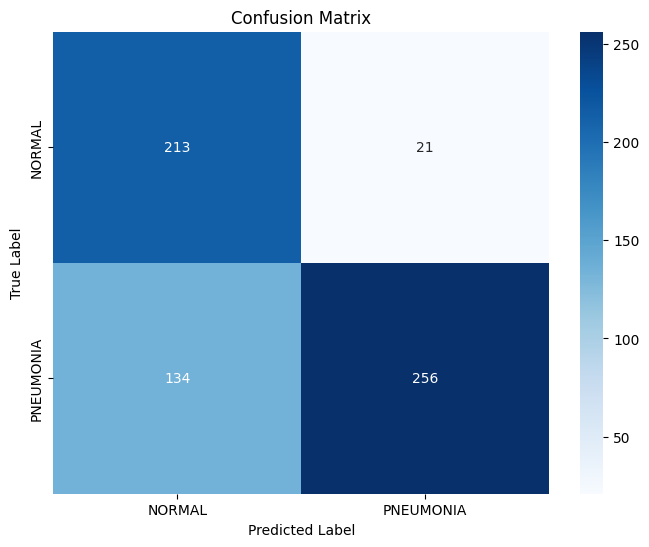

In [16]:
cm = confusion_matrix(test_labels, predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

6. ROC Curve and AUC:

The Receiver Operating Characteristic (ROC) curve illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The Area Under the Curve (AUC) provides a single metric summarizing performance across all thresholds.

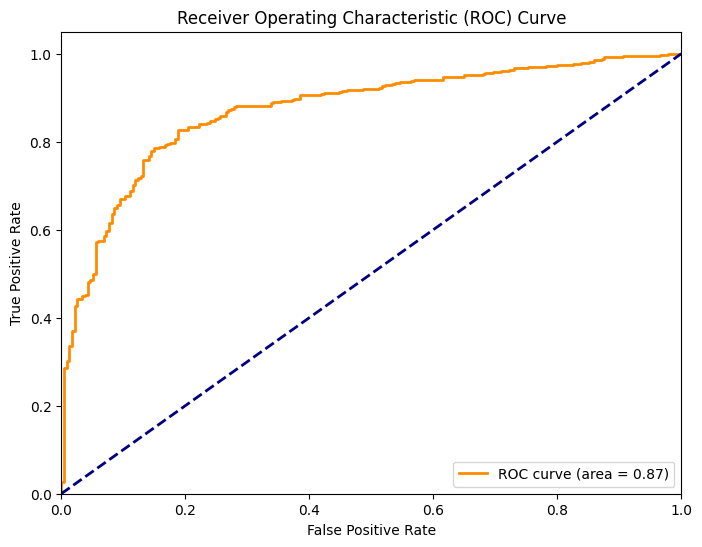

In [17]:
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(test_labels, predictions_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

7. Plot Training History:

Visualizing the training and validation accuracy and loss over epochs helps in understanding model convergence and potential overfitting.

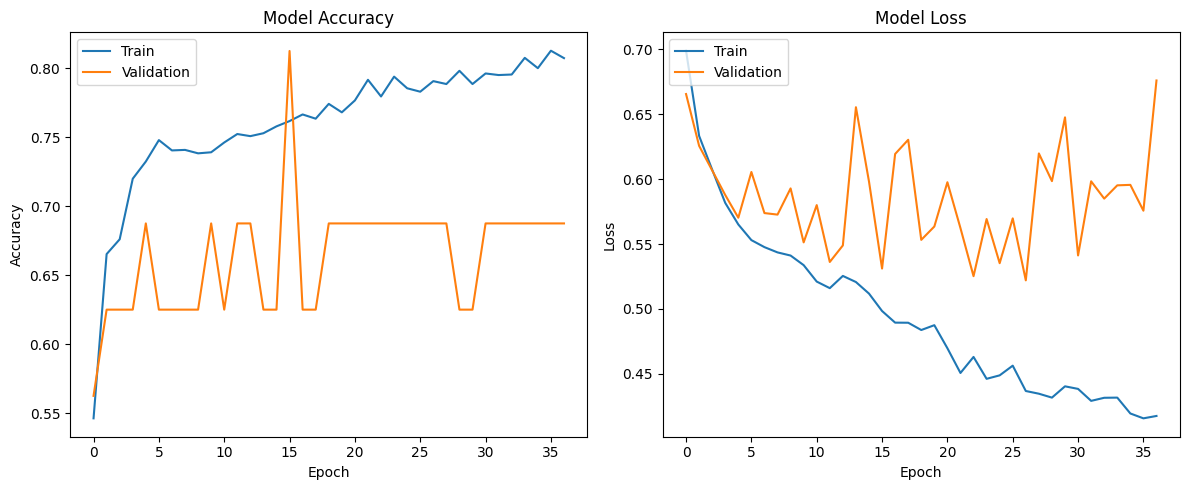

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

### Conclusion on Model Performance

The model demonstrates an overall accuracy of 75% in classifying Chest X-Ray images as NORMAL or PNEUMONIA.

Breaking down performance by class:

For the NORMAL class, the model achieves a high recall of 91%, indicating its strong ability to correctly identify the vast majority of patients who do not have pneumonia. Its precision for NORMAL stands at 61%, meaning that when the model predicts a case as normal, it is correct approximately two-thirds of the time.

For the critical PNEUMONIA class, the model shows robust precision at 92%. This is highly favorable, as it means that when the model identifies a patient as having pneumonia, that prediction is very likely to be correct. However, its recall for PNEUMONIA is 66%. While this indicates the model correctly detects two-thirds of actual pneumonia cases, it also implies that approximately one-third of patients with pneumonia are missed (false negatives).

In summary, the model provides a balanced performance with strong overall accuracy. Its high precision for PNEUMONIA is a key strength for confident diagnoses. However, for a medical diagnostic tool where missing a disease can have serious consequences, the PNEUMONIA recall of 66% presents an area for potential improvement. Future efforts should consider strategies to further enhance the detection rate of PNEUMONIA, even if it entails a slight adjustment to the current high precision, to minimize the occurrence of false negatives in a clinical setting.